In [1]:
%%capture
!pip install arabert transformers tensorflow

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from arabert.preprocess import ArabertPreprocessor
from transformers import TFAutoModel, AutoTokenizer
from transformers import TFBertForSequenceClassification

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, Precision, Recall

2024-05-26 06:48:25.714716: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 06:48:25.714835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 06:48:25.868309: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Loading

In [3]:
train = pd.read_csv('/kaggle/input/bert-arabic-dialect/DL cleaned Data/DL_cleaned_train.csv')
test =  pd.read_csv('/kaggle/input/bert-arabic-dialect/DL cleaned Data/DL_cleaned_test.csv')

In [4]:
print(train.shape)
print(test.shape)

(118166, 2)
(29545, 2)


In [5]:
# Merge the models to perform Downsampling
df = pd.concat((train, test), axis =0)

In [6]:
df.shape

(147711, 2)

* Training Examples: 118,084 tweets from different 5 Arab countries (Egypt, Morroco, Lybia, Lebanon and Sudan).
* Test Examples: 29,533 tweets.

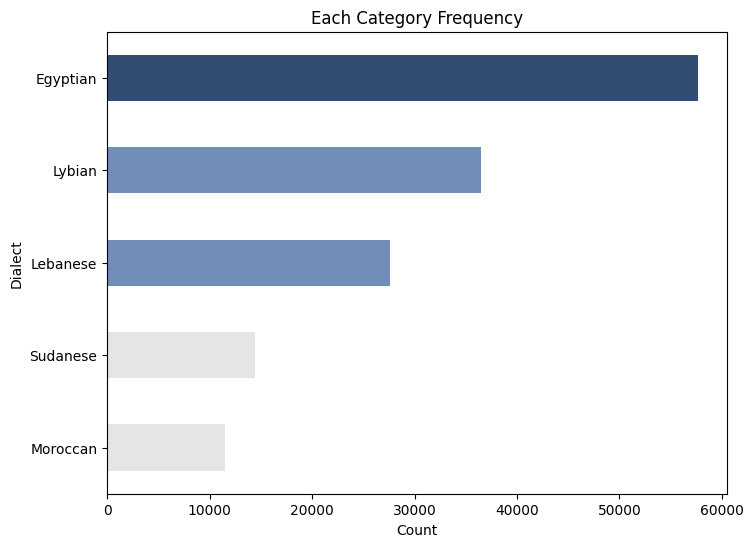

In [7]:
df2 = df.copy()
fig = plt.figure(figsize=(8,6))
colors = ['#e5e5e5','#e5e5e5','#708eb8','#708eb8','#324d72','#324d72']
df2['Dialect'] = df2['Dialect'].map({'LY':'Lybian', 'EG':'Egyptian','MA':'Moroccan','LB':'Lebanese','SD':'Sudanese'})
df2['Dialect'].value_counts().sort_values().plot.barh(color=colors, title= 'Each Category Frequency')
plt.xlabel('Count', fontsize = 10);

**The dataset shows that the Egyptian dialect has the highest representation, followed by the Libyan and Lebanese dialects. The Sudanese and Moroccan dialects have fewer tweets in comparison. Since there is significant class imbalance that could affect model performance, we could apply downsampling to equalize all categories.**

In [8]:
print(df.isna().sum())

print(df.isna().sum())

print(df.duplicated().sum())

print(df.duplicated().sum())

Text       0
Dialect    0
dtype: int64
Text       0
Dialect    0
dtype: int64
2
2


In [9]:
df.dropna(inplace = True)
df.dropna(inplace = True)
df.drop_duplicates(inplace = True)
df.drop_duplicates(inplace = True)

In [10]:
class_counts = df['Dialect'].value_counts()
print(class_counts)

Dialect
EG    57633
LY    36495
LB    27614
SD    14429
MA    11538
Name: count, dtype: int64


In [11]:
# Determine the size of the smallest class
min_class_count = class_counts.min()
print("Minimum class count",min_class_count)

Minimum class count 11538


In [12]:
median_class_count = round(class_counts.median())
print("Median class count",median_class_count)
# We can choose a middle ground e.g. 27.6k to not lose so much data

Median class count 27614


## Downsampling the Dataset

In [13]:
# Downsample each class to the mean class count
downsampled_dfs = []

# If the samples no greater than the mean >> resample else >> take all the data
for dialect in df['Dialect'].unique():
    dialect_subset = df[df['Dialect'] == dialect]
    if len(dialect_subset) >= median_class_count:
        downsampled_dialect = resample(dialect_subset, 
                                       replace=False, 
                                       n_samples=median_class_count, 
                                       random_state=42)
    else:
        # If there are not enough samples, just use the available samples
        downsampled_dialect = dialect_subset
    downsampled_dfs.append(downsampled_dialect)

# Combine the downsampled subsets
downsampled_df = pd.concat(downsampled_dfs)

# Shuffle the dataset to mix the samples from different classes
downsampled_df = downsampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Downsampling complete. The classes have been equalized.")

Downsampling complete. The classes have been equalized.


In [14]:
downsampled_df['Dialect'].value_counts()

Dialect
LB    27614
LY    27614
EG    27614
SD    14429
MA    11538
Name: count, dtype: int64

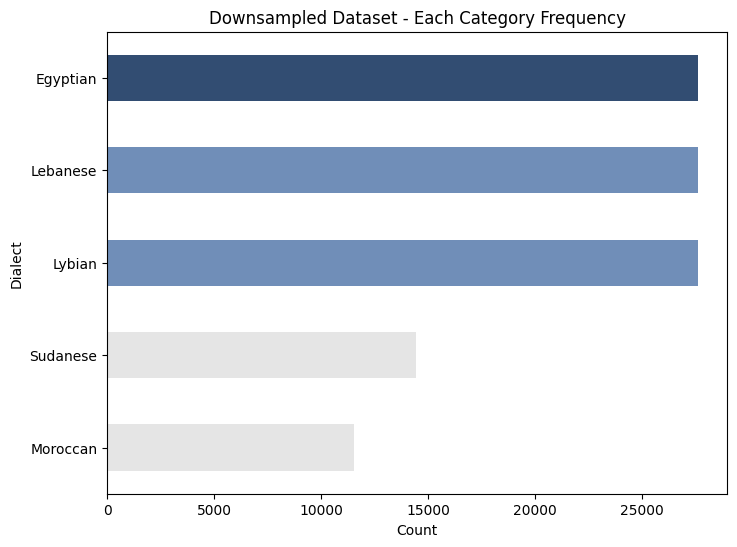

In [15]:
df2 = downsampled_df.copy()
fig = plt.figure(figsize=(8,6))
colors = ['#e5e5e5','#e5e5e5','#708eb8','#708eb8','#324d72','#324d72']
df2['Dialect'] = df2['Dialect'].map({'LY':'Lybian', 'EG':'Egyptian','MA':'Moroccan','LB':'Lebanese','SD':'Sudanese'})
df2['Dialect'].value_counts().sort_values().plot.barh(color=colors)
plt.xlabel('Count', fontsize = 10)
plt.title('Downsampled Dataset - Each Category Frequency');

In this dataset, we initially had the following distribution of data points across dialects:

- **EG**: 57,633
- **LY**: 36,495
- **LB**: 27,614
- **SD**: 14,429
- **MA**: 11,538

We downsampled the data for the dialects with a the median of data points to slightly match the count of the dialect with the smallest number of data points. 
The downsampling process resulted in the following distribution:

- **LB**: 27,614
- **LY**: 27,614
- **EG**: 27,614
- **SD**: 14,429
- **MA**: 11,538

*While there is still some imbalance in the dataset, this approach has improved the balance compared to the original distribution. 
This helps in mitigating bias that may arise due to disproportionate representation of certain dialects in the dataset.*

In [16]:
# Calculate the length of each statement in X_train
statement_lengths = [len(str(statement).split()) for statement in downsampled_df['Text']]

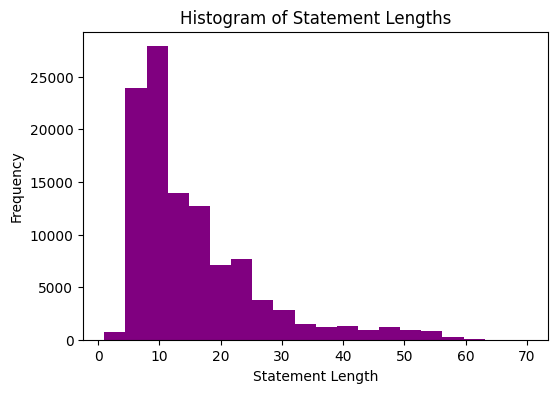

In [17]:
plt.figure(figsize=(6,4))
plt.hist(statement_lengths, bins=20,color='purple')
plt.xlabel('Statement Length')
plt.ylabel('Frequency')
plt.title('Histogram of Statement Lengths')
plt.show()

- each statement ranges from around 4 to 70 token

# Splitting the Data

In [59]:
# Training Data
X = downsampled_df['Text']
y = downsampled_df['Dialect']

# Splitting Data to 80% train and 20% test
X_train, X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, stratify=y,  random_state=42)

In [63]:
X_train = X_train.reset_index(drop= True)
X_test = X_test.reset_index(drop= True)
y_train = y_train.reset_index(drop= True)
y_test = y_test.reset_index(drop= True)

In [65]:
print(X_train.shape)
print(X_test.shape)

(87047,)
(21762,)


### Encoding the categories

In [66]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
print("Original labels:", set(y_train))
print("Encoded labels:", set(y_train_encoded))

Original labels: {'LY', 'LB', 'EG', 'MA', 'SD'}
Encoded labels: {0, 1, 2, 3, 4}


# BERT Model 🤗
- BERT is a bidirectional transformer pretrained using a combination of masked language modeling objective and next sentence prediction on a large corpus comprising the Toronto Book Corpus and Wikipedia.

- **BERT Architecture:**
    * `BERT BASE` has **12** layers in the Encoder stack while `BERT LARGE` has **24** layers in the Encoder stack. 
    * BERT architectures (BASE and LARGE) also have larger feedforward networks (**768** and **1024** hidden units respectively), and more attention heads (**12** and **16** respectively).
    * `BERT BASE` contains **110M** parameters while `BERT LARGE` has **340M** parameters.

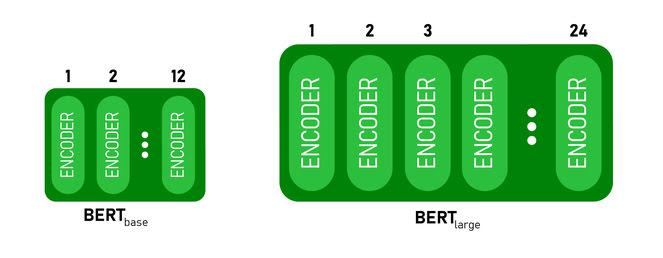

## AraBERT 🤗
* AraBERT is an Arabic pretrained language model based on Google's BERT architecture and uses the same BERT-Base configuration.
* We chose to fine-tune **AraBERTv0.2-base** from *Hugging Face* for our task. 

### AraBERTv0.2-base
- `AraBERTv0.2-base` is one of the latest version of AraBERT.
- `AraBERTv0.2-base` includes 12 encoder layers, while larger version,`AraBERTv0.2-large` has 24 encoder layers. 
- While the larger model might offer better performance due to its increased capacity, we chose the base version to avoid computational overhead.
- `AraBERTv0.2-base` It offers a large parameter size with 136 million parameters.
- This version does not employ pre-segmentation.
- Trained on a massive dataset consisting of 200 million sentences, 77GB in size, and encompassing 8.6 billion words.

For more details, please refer to the [AraBERT Paper](https://arxiv.org/abs/2003.00104) and the [AraBERT Meetup](https://www.youtube.com/watch?v=sgLdnDhtJpE).


In [67]:
urllib3.disable_warnings()

# Make the request without certificate verification
response = requests.get('https://farasa-api.qcri.org', verify=False)

# Print the response status code
print(response.status_code)

200


In [68]:
# BERT excpect input as list of strings
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()

- Removing punctuation and special characters
- Normalizing diacritics
- Segmenting text into words

In [69]:
model_name="aubmindlab/bert-base-arabertv2"
# Load AraBert tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False, pad_token_id=0)
# Load AraBert
model = TFAutoModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already u

In [70]:
X_train.head()

0    @USER اكبر منافق هيدا بدو يستغل التظاهرات كرما...
1    @USER طيب بتقفلي الخاص حقك كيف بتلغي الاوبشن م...
2                @USER @USER مكن يشيلو من زول دمه NUM؟
3      @USER اليوم ده البميزو عن باقي الايام شنو EMOJI
4       مرات جمله " شن جوك ؟ " يكون معناها " شن جابك "
Name: Text, dtype: object

In [71]:
# Define the tokenize function
def tokenize(text):
    return tokenizer(
    text,
    padding='max_length',  # Pad to the maximum length of the model's input
    truncation=True,       # Truncate sequences longer than the maximum length
    max_length=80        # Set the maximum sequence length 
    )


# Tokenize data
X_train_tokenized = X_train.apply(tokenize)

X_test_tokenized = X_test.apply(tokenize)

In [72]:
print("Padding token ID:", tokenizer.pad_token_id)

Padding token ID: 31


Tokenizer arguments:
- padding="max_length": Pads sequences to a fixed length (around 80), as the previous plot showed statement ranges from around 4 to 70 token
- truncation=True: Truncates sequences exceeding the maximum length. 

In [73]:
X_train_tokenized

0        [input_ids, token_type_ids, attention_mask]
1        [input_ids, token_type_ids, attention_mask]
2        [input_ids, token_type_ids, attention_mask]
3        [input_ids, token_type_ids, attention_mask]
4        [input_ids, token_type_ids, attention_mask]
                            ...                     
87042    [input_ids, token_type_ids, attention_mask]
87043    [input_ids, token_type_ids, attention_mask]
87044    [input_ids, token_type_ids, attention_mask]
87045    [input_ids, token_type_ids, attention_mask]
87046    [input_ids, token_type_ids, attention_mask]
Name: Text, Length: 87047, dtype: object

In [74]:
# the padding tokens is 31
X_train_tokenized[0]

{'input_ids': [33, 64, 21111, 16837, 17778, 16695, 35581, 9906, 8401, 1152, 1401, 440, 4031, 292, 2303, 1614, 6202, 48, 419, 4135, 1463, 6958, 445, 419, 8151, 221, 419, 4135, 2325, 2344, 1288, 739, 4967, 421, 19259, 492, 223, 9030, 218, 407, 8765, 419, 12534, 23573, 34, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [76]:
# Convert X_train_tokenized to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': np.array([sample['input_ids'] for sample in X_train_tokenized]),
        'attention_mask': np.array([sample['attention_mask'] for sample in X_train_tokenized]),
        'token_type_ids': np.array([sample['token_type_ids'] for sample in X_train_tokenized])
    },
    y_train_encoded
))

# Set batch size and shuffle
BATCH_SIZE = 64

train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(buffer_size=len(X_train_tokenized))

# Repeat the same process for the test dataset

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': np.array([sample['input_ids'] for sample in X_test_tokenized]),
        'attention_mask': np.array([sample['attention_mask'] for sample in X_test_tokenized]),
        'token_type_ids': np.array([sample['token_type_ids'] for sample in X_test_tokenized])
    },
    y_test_encoded
))
test_dataset = test_dataset.batch(BATCH_SIZE)


In [77]:
ip, out = next(iter(train_dataset)) # a batch from train_dataset
print(ip, '\n\n', out)

{'input_ids': <tf.Tensor: shape=(64, 80), dtype=int64, numpy=
array([[   33,    64, 21111, ...,    31,    31,    31],
       [   33,   331,  4838, ...,    31,    31,    31],
       [   33, 34670,  2607, ...,    31,    31,    31],
       ...,
       [   33, 40497,  2331, ...,    31,    31,    31],
       [   33,    64, 21111, ...,    31,    31,    31],
       [   33,    64, 21111, ...,    31,    31,    31]])>, 'attention_mask': <tf.Tensor: shape=(64, 80), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'token_type_ids': <tf.Tensor: shape=(64, 80), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>} 

 tf.Tensor(
[2 1 2 0 2 1 1 0 0 4 2 2 0 

In [78]:
import tensorflow as tf

class ARABERTForClassification(tf.keras.Model):
    """
    ARABERTForClassification is a custom TensorFlow model for text classification tasks. It uses a pre-trained
    ARABERT model as a feature extractor and adds a fully connected layer for classification.

    Attributes:
    __________
        bert (tf.keras.Model): The pre-trained ARABERT model.
        fc (tf.keras.layers.Dense): A fully connected layer with softmax activation for classification.
    """
    
    def __init__(self, model, num_classes):
        """
        Initializes the ARABERTForClassification model.

        Args:
        ____
            model (tf.keras.Model): The pre-trained ARABERT model.
            num_classes (int): The number of classes for the classification task.
        """
        super().__init__()
        self.bert = model
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        """
        Forward pass of the model.

        Args:
        ____
            inputs (tf.Tensor): Input tensor containing token ids, attention masks, and  token type ids.

        Returns:
        _______
            tf.Tensor: Output tensor with shape (batch_size, num_classes), containing the probabilities for each class.
        """
        x = self.bert(inputs)[1]  # Use the pooled output from BERT
        return self.fc(x)


In [79]:
NUM_CLASSES = len(set(y_train_encoded))
lr = 1e-5
classifier = ARABERTForClassification(model, num_classes=NUM_CLASSES)

classifier.compile(
    optimizer=Adam(learning_rate=lr),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [80]:
history = classifier.fit(
    train_dataset,
    epochs=4
)

Epoch 1/4


I0000 00:00:1716706860.450548     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1361/1361 [==============================] - 824s 566ms/step - loss: 0.6854 - accuracy: 0.7473
Epoch 2/4
1361/1361 [==============================] - 770s 566ms/step - loss: 0.4676 - accuracy: 0.8322
Epoch 3/4
1361/1361 [==============================] - 770s 565ms/step - loss: 0.3129 - accuracy: 0.8927
Epoch 4/4
1361/1361 [==============================] - 770s 566ms/step - loss: 0.1606 - accuracy: 0.9482


In [81]:
results = classifier.evaluate(test_dataset)

print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

341/341 [==============================] - 78s 202ms/step - loss: 0.6339 - accuracy: 0.8169
Test Loss: 0.6339284181594849
Test Accuracy: 0.8169285655021667


In [82]:
predictions = classifier.predict(test_dataset)
predicted_labels = tf.argmax(predictions, axis=-1).numpy()

341/341 [==============================] - 77s 199ms/step


In [83]:
CLASS_NAMES = ['EG', 'SD', 'LY', 'LB', 'MA']
print(classification_report(y_test_encoded, predicted_labels, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

          EG       0.78      0.90      0.83      5523
          SD       0.90      0.84      0.87      5523
          LY       0.82      0.79      0.81      5523
          LB       0.85      0.72      0.78      2307
          MA       0.72      0.74      0.73      2886

    accuracy                           0.82     21762
   macro avg       0.82      0.80      0.80     21762
weighted avg       0.82      0.82      0.82     21762



The model achieves an overall accuracy of 82%, indicating it correctly classifies the majority of the tweets.

- Class Imbalance:
    * The higher support for Egyptian, Sudanese, and Libyan dialects suggests that these classes are better represented and hence better predicted.
    * Lower performance in the Lebanese and Moroccan dialects indicates the need for potential data augmentation or model tuning for these minority classes.

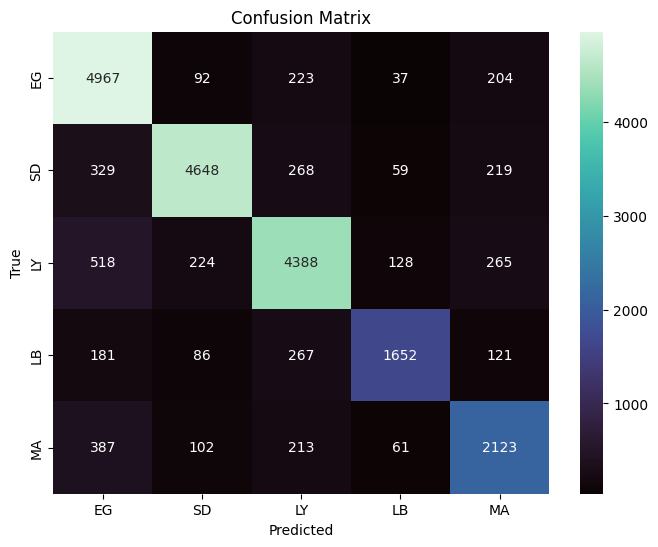

In [84]:
cm = confusion_matrix(y_test_encoded, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='mako', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

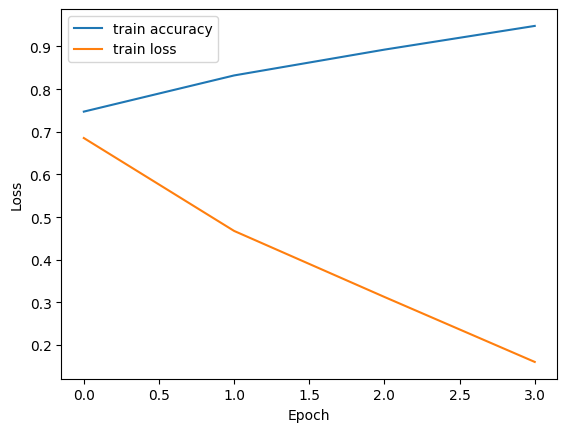

In [85]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['loss'], label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Loading the pre-trained Model

In [178]:
model = TFAutoModel.from_pretrained("aubmindlab/bert-base-arabertv2")

# Print the model architecture
print(model.summary())

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already u

Model: "tf_bert_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  135193344 
                                                                 
Total params: 135193344 (515.72 MB)
Trainable params: 135193344 (515.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### Preprocessing Input Data

In [133]:
model_name="aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False, pad_token_id=0)

In [93]:
def preprocess_input(text):
    # Tokenize the text
    tokenized_input = tokenizer(text, padding='max_length', truncation=True, max_length=80)
    return tokenized_input

### Make Prediction

In [101]:
def predict_dialect(text, model):
    # Preprocess the input text
    tokenized_text = preprocess_input(text)
    
    # Convert tokenized text to tensors and add batch dimension
    input_ids = tf.expand_dims(tokenized_text['input_ids'], axis=0)
    attention_mask = tf.expand_dims(tokenized_text['attention_mask'], axis=0)
    token_type_ids = tf.expand_dims(tokenized_text['token_type_ids'], axis=0)
    
    # Get the model's prediction
    predictions = model({
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_type_ids
    }, training=False)
    
    predicted_label = tf.argmax(predictions, axis=-1).numpy()[0]
    
    # Return the predicted label
    return predicted_label

In [ ]:
label_encoder.inverse_transform([0,1,2,3,4])
classes = {0:'Egyptian',
           1: 'Lebanese',
           2: 'Lybian',
           3: 'Moroccan ',
           4: 'Sudanese'}

In [111]:
predicted_label = predict_dialect(text="بعيدا هردميسه وين ماشي رد بالك", model=classifier)
print("Predicted label:", classes[predicted_label])

Predicted label: Lybian


In [112]:
predicted_label = predict_dialect(text="باشا ازيك عامل ايه", model=classifier)
print("Predicted label:", classes[predicted_label])

Predicted label: Egyptian


In [113]:
predicted_label = predict_dialect(text="اللي يشوفك يعطيك اصغر عمرك جعبة", model=classifier)
print("Predicted label:", classes[predicted_label])

Predicted label: Lybian


In [117]:
predicted_label = predict_dialect(text="يلّي باعك ببصلة، بيعو بقشرتها! يلّي بيعملك حمار، البُطة! إذا قلتلَّك تقبرني بتجيب المجرفة وبتطمني", model=classifier)
print("Predicted label:", classes[predicted_label])

Predicted label: Lebanese


In [120]:
predicted_label = predict_dialect(text="·التسويها بايدك تغلب اجاويدك", model=classifier)
print("Predicted label:", classes[predicted_label])

Predicted label: Sudanese
True label: Sudanese
